# Convolutional Neural Networks (CNNs)
## Author: Gian Carlo Alix
<i><b>Disclaimer: </b>Note that this Machine Learning project was used as an Assignment Submission and<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; thereby is <b>copyrighted</b>. No part of this Notebook may be used for<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; replication, publication, and submission. This is merely for reference only<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; and to showcase a demonstrative example of Neural Networks in Machine Learning.<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Use as reference only; include citations; and use of material is at your own risk!</i>

### The FaceScrub Dataset
<img src="img/facescrub.png">
In this project, we will be using CNNs to train a convolutional neural network model with the FaceScrub Dataset: http://vintage.winklerbros.net/facescrub.html. Two tasks: face recognition task and gender recognition task.

We begin by importing the necessary modules and packages.

In [1]:
# Import necessary modules and packages
import tensorflow as tf
import numpy as np
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

We then define a function to load the dataset.

In [2]:
def data_segmentation(data_path, target_path, task):
    # task = 0 >> select the name ID targets for face recognition task
    # task = 1 >> select the gender ID targets for gender recognition
    data = np.load(data_path)/255
    data = np.reshape(data, [-1, 32*32])
    
    target = np.load(target_path)
    
    np.random.seed(45689)
    rnd_idx = np.arange(np.shape(data)[0])
    np.random.shuffle(rnd_idx)
    
    trBatch = int(0.8*len(rnd_idx))
    validBatch = int(0.1*len(rnd_idx))
    
    trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
                                    data[rnd_idx[trBatch+1:trBatch+validBatch],:], \
                                    data[rnd_idx[trBatch+validBatch+1:-1],:]
    
    trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
                                            target[rnd_idx[trBatch+1:trBatch+validBatch], task], \
                                            target[rnd_idx[trBatch+validBatch+1:-1], task]
    
    return trainData, validData, testData, trainTarget, validTarget, testTarget

    # data and target for fae recognition and gender recognition tasks (0 for face, 1 for gender)
trainData0, validData0, testData0, trainTarget0, validTarget0, testTarget0 = data_segmentation('data.npy', 'target.npy', 0)
trainData1, validData1, testData1, trainTarget1, validTarget1, testTarget1 = data_segmentation('data.npy', 'target.npy', 1)

Let's query in the shapes of our training data and target.

In [3]:
print(trainData0.shape)
print(trainData1.shape)
print(trainTarget0.shape)
print(trainTarget1.shape)

(747, 1024)
(747, 1024)
(747,)
(747,)


### Convolutional Layer, Max Pooling Layer and Fully Connected Layer
In our convolutional neural network, it will be composed of one convolutional layer, one max-pool layer, and two hidden unit layers. And here is the code for that listed as three Python functions

In [4]:
# Helper Function for Creating a 2D Convolutional Layer
# Input: X - input tensor, weight, bias and stride
# Output: A 2D Convolution
def convolution_2D_layer(X, weight, bias, strides):
    X = tf.nn.conv2d(X, weight, strides=[1, strides, strides, 1], padding='SAME')
    X = tf.nn.bias_add(X, bias)
    relu_X = tf.nn.relu(X)
    return relu_X

In [5]:
# Helper Function for Creating a Max Pool Layer
# Input: X - input tensor, ksize of the tensor, and the stride
# Output: The Max Pool Layer
def max_pool_layer(X, k_size, stride):
    return tf.nn.max_pool(X, ksize=[1, k_size, k_size, 1], strides=[1, stride, stride, 1], padding='SAME')

In [6]:
s_strides = 1 # define the strides

# Create the CNN model
# Input: Input tensor X, the weights of the CNN network, the biases and the dropout value
# Output: Output tensor y
def cnn(X, weights, biases, dropout):
    # Reshape the tensor
    X = tf.reshape(X, shape=[-1,32,32,1])
    
    # Convolutional Layer
    conv = convolution_2D_layer(X, weights['conv_weight'], biases['conv_bias'], s_strides)
    
    # Max-Pool Layer
    conv = max_pool_layer(conv, 3, s_strides+1)    # 3x3 size of stride 2
    
    # Fully Connected Layer - Similar to the one from Assignment 2
    # With 2 hidden layers
    hidden_1 = tf.reshape(conv, [-1, weights['hidden_1_weight'].get_shape().as_list()[0]])
    hidden_1 = tf.add(tf.matmul(hidden_1, weights['hidden_1_weight']), biases['hidden_1_bias'])
    hidden_1 = tf.nn.relu(hidden_1)
    hidden_1 = tf.nn.dropout(hidden_1, dropout)
    
    hidden_2 = tf.reshape(hidden_1, [-1, weights['hidden_2_weight'].get_shape().as_list()[0]])
    hidden_2 = tf.add(tf.matmul(hidden_1, weights['hidden_2_weight']), biases['hidden_2_bias'])
    hidden_2 = tf.nn.relu(hidden_2)
    hidden_2 = tf.nn.dropout(hidden_2, dropout)
    
    # The Output Layer
    output = tf.add(tf.matmul(hidden_2, weights['out_weight']), biases['out_bias'])
    
    return output

Now let us define some variables and parameters for our model.

In [7]:
# Define variables
learning_rates = [0.001, 0.0005] # We define two learning rates for tweaking hyperparameters
dropouts = [0.5, 0.8, 1.0] # We define three possible dropout values
batch_size = 93
epochs = 50
step_size = 10
n_inputs = 32*32
hidden_units_1 = 384
hidden_units_2 = 192
n_classes = [6, 2] # For task 1, there are 6 celebrities; For task 2, there are 2 genders
X0 = tf.placeholder(tf.float32, [None, n_inputs]) # input tensor for facial
X1 = tf.placeholder(tf.float32, [None, n_inputs]) # input tensor for gender
y0 = tf.placeholder(tf.float32, [None, n_classes[0]]) # output tensor for task 0
y1 = tf.placeholder(tf.float32, [None, n_classes[1]]) # output tensor for task 1
keep_prob = tf.placeholder(tf.float32) # for the dropout; keeping probability

# Glorot Initializer is same as Xavier Initializer, to be ued for the weights and biases
initializer = tf.glorot_normal_initializer()

# Define weights for task 0
weights0 = {
    'conv_weight': tf.Variable(initializer([5,5,1,32])),
    'hidden_1_weight': tf.Variable(initializer([16*16*32, hidden_units_1])),
    'hidden_2_weight': tf.Variable(initializer([hidden_units_1, hidden_units_2])),
    'out_weight': tf.Variable(initializer([hidden_units_2, n_classes[0]]))
}

# Define biases for task 0
biases0 = {
    'conv_bias': tf.Variable(initializer([32])),
    'hidden_1_bias': tf.Variable(initializer([hidden_units_1])),
    'hidden_2_bias': tf.Variable(initializer([hidden_units_2])),
    'out_bias': tf.Variable(initializer([n_classes[0]]))
}

# Weights and biases for task 1
weights1 = {
    'conv_weight': tf.Variable(initializer([5,5,1,32])),
    'hidden_1_weight': tf.Variable(initializer([16*16*32, hidden_units_1])),
    'hidden_2_weight': tf.Variable(initializer([hidden_units_1, hidden_units_2])),
    'out_weight': tf.Variable(initializer([hidden_units_2, n_classes[1]]))
}

# Define biases for task 1
biases1 = {
    'conv_bias': tf.Variable(initializer([32])),
    'hidden_1_bias': tf.Variable(initializer([hidden_units_1])),
    'hidden_2_bias': tf.Variable(initializer([hidden_units_2])),
    'out_bias': tf.Variable(initializer([n_classes[1]]))
}

Instructions for updating:
Colocations handled automatically by placer.


One question asked is what is the shape of the output tensor dimensions if we used 64 filters of 5x5 kernels and stride of 1. Then we get (?, 6) where ? is the number of inputs

In [8]:
weights0['conv_weight'] = tf.Variable(initializer([5,5,1,64]))
weights0['hidden_1_weight'] = tf.Variable(initializer([16*16*64, hidden_units_1]))
biases0['conv_bias'] = tf.Variable(initializer([64]))

output_tensor = cnn(X0, weights0, biases0, keep_prob)
print("If we used 64 filters of 5x5 kernels with stride 1, then the dimensions of the output tensor is ",
      output_tensor.shape)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
If we used 64 filters of 5x5 kernels with stride 1, then the dimensions of the output tensor is  (?, 6)


Another question asked was that what is the shape of the output tensor dimensions if we used 32 filters of 7x7 and a stride of 2?

In [10]:
s_strides = 2
weights0['conv_weight'] = tf.Variable(initializer([7,7,1,32]))
weights0['hidden_1_weight'] = tf.Variable(initializer([16*16*32, hidden_units_1]))
biases0['conv_bias'] = tf.Variable(initializer([32]))

output_tensor = cnn(X0, weights0, biases0, keep_prob)
print("If we used 32 filters of 7x7 kernels with stride 2, then the dimensions of the output tensor is ",
      output_tensor.shape)

If we used 32 filters of 7x7 kernels with stride 2, then the dimensions of the output tensor is  (?, 6)


Therefore, as we can see the shape dimension is still the same. Now let us revert back to the original conditions and we will start training.

In [11]:
# Reset everything back
s_strides = 1

def cnn(X, weights, biases, dropout):
    X = tf.reshape(X, shape=[-1,32,32,1])
    conv = convolution_2D_layer(X, weights['conv_weight'], biases['conv_bias'], s_strides)
    conv = max_pool_layer(conv, 3, s_strides+1)
    
    hidden_1 = tf.reshape(conv, [-1, weights['hidden_1_weight'].get_shape().as_list()[0]])
    hidden_1 = tf.add(tf.matmul(hidden_1, weights['hidden_1_weight']), biases['hidden_1_bias'])
    hidden_1 = tf.nn.relu(hidden_1)
    hidden_1 = tf.nn.dropout(hidden_1, dropout)
    
    hidden_2 = tf.reshape(hidden_1, [-1, weights['hidden_2_weight'].get_shape().as_list()[0]])
    hidden_2 = tf.add(tf.matmul(hidden_1, weights['hidden_2_weight']), biases['hidden_2_bias'])
    hidden_2 = tf.nn.relu(hidden_2)
    hidden_2 = tf.nn.dropout(hidden_2, dropout)
    
    output = tf.add(tf.matmul(hidden_2, weights['out_weight']), biases['out_bias'])
    return output

learning_rates = [0.001, 0.0005] 
dropouts = [0.5, 0.8, 1.0]
batch_size = 93
epochs = 50
step_size = 10
n_inputs = 32*32
hidden_units_1 = 384
hidden_units_2 = 192
n_classes = [6, 2]
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs]) 
y0 = tf.placeholder(tf.float32, [None, n_classes[0]]) 
y1 = tf.placeholder(tf.float32, [None, n_classes[1]]) 
keep_prob = tf.placeholder(tf.float32) 

initializer = tf.glorot_normal_initializer()
weights0 = {
    'conv_weight': tf.Variable(initializer([5,5,1,32])),
    'hidden_1_weight': tf.Variable(initializer([16*16*32, hidden_units_1])),
    'hidden_2_weight': tf.Variable(initializer([hidden_units_1, hidden_units_2])),
    'out_weight': tf.Variable(initializer([hidden_units_2, n_classes[0]]))
}
biases0 = {
    'conv_bias': tf.Variable(initializer([32])),
    'hidden_1_bias': tf.Variable(initializer([hidden_units_1])),
    'hidden_2_bias': tf.Variable(initializer([hidden_units_2])),
    'out_bias': tf.Variable(initializer([n_classes[0]]))
}
weights1 = {
    'conv_weight': tf.Variable(initializer([5,5,1,32])),
    'hidden_1_weight': tf.Variable(initializer([16*16*32, hidden_units_1])),
    'hidden_2_weight': tf.Variable(initializer([hidden_units_1, hidden_units_2])),
    'out_weight': tf.Variable(initializer([hidden_units_2, n_classes[1]]))
}
biases1 = {
    'conv_bias': tf.Variable(initializer([32])),
    'hidden_1_bias': tf.Variable(initializer([hidden_units_1])),
    'hidden_2_bias': tf.Variable(initializer([hidden_units_2])),
    'out_bias': tf.Variable(initializer([n_classes[1]]))
}

### Learning
Before we begin learning, we need to first build our model, then have it evaluated.

In [12]:
# Model, Loss and Optimizer for Task 0
logits0 = cnn(X0, weights0, biases0, keep_prob)
prediction0 = tf.nn.softmax(logits0)
loss0 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits0, labels=y0))
opt0 = tf.train.AdamOptimizer(learning_rate=learning_rates[0])
train_op0 = opt0.minimize(loss0)

# Model, Loss and Optimizer for Task 1
logits1 = cnn(X1, weights1, biases1, keep_prob)
prediction1 = tf.nn.softmax(logits1)
loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits1, labels=y1))
opt1 = tf.train.AdamOptimizer(learning_rate=learning_rates[0])
train_op1 = opt1.minimize(loss1)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
# Evaluate models for task 0 and task 1
predicted_value_0 = tf.argmax(prediction0, 1)
predicted_value_1 = tf.argmax(prediction1, 1)
actual_value_0 = tf.argmax(y0,1)
actual_value_1 = tf.argmax(y1,1)
correct_predictions0 = tf.equal(predicted_value_0, actual_value_0)
acc_0 = tf.reduce_mean(tf.cast(correct_predictions0, tf.float32))
correct_predictions1 = tf.equal(predicted_value_1, actual_value_1)
acc_1 = tf.reduce_mean(tf.cast(correct_predictions1, tf.float32))

Before training our network, let us first apply one hot encoding to our vectors to easily match shape when training.

In [14]:
# Given a label, convert it to one-hot vector
def label_encoder(label, classes):
   one_hot_vector = np.zeros((classes,1))
   one_hot_vector[label] = 1;
   return one_hot_vector.T

# Given a numpy array, convert to one-hot array
def one_hot_encoder(arr, classes):
   one_hot = []
   for x in np.nditer(arr):
        one_hot_label = label_encoder(x, classes)
        one_hot.append(one_hot_label)
   return np.concatenate(one_hot, axis=0)

# Use the above methods to transform the targets into one hot arrays
newTrainTarget0 = one_hot_encoder(trainTarget0, n_classes[0])
newValidTarget0 = one_hot_encoder(validTarget0, n_classes[0])
newTestTarget0 = one_hot_encoder(testTarget0, n_classes[0])
newTrainTarget1 = one_hot_encoder(trainTarget1, n_classes[1])
newValidTarget1 = one_hot_encoder(validTarget1, n_classes[1])
newTestTarget1 = one_hot_encoder(testTarget1, n_classes[1])

<b>We begin training finally!</b>

In [15]:
# Assign a random integer
rand = np.random.randint(low=0, high=93-1, size=1)

# Train the model  for task 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Initialize some utility lists for plotting later
    training_loss_0 = []
    validation_loss_0 = []
    training_acc_0 = []
    validation_acc_0 = []
    epochs_list = []
    
    # Do Training on Facial Recognition for 50 epochs
    for epoch in range(epochs):
        
        # Creating batches
        batch_train0 = np.shape(trainData0)[0]
        total_batch0 = int(batch_train0/batch_size)
        train_batches_X0 = np.array_split(trainData0[:744], total_batch0)
        train_batches_Y0 = np.array_split(newTrainTarget0[:744], total_batch0)
        
        # We do batch training
        for i in range(total_batch0):
            train_batch_x0, train_batch_y0 = train_batches_X0[i], train_batches_Y0[i]
            train_batch_x0 = train_batch_x0.reshape(batch_size, n_inputs)
            train_batch_y0 = train_batch_y0.reshape(batch_size, n_classes[0])
            
            # BackProps for Tasks 0
            sess.run(train_op0,feed_dict={X0: train_batch_x0, y0: train_batch_y0, keep_prob: dropouts[0]})
            
            # Output the cross entropy loss and training accuracies per epoch
            if i % step_size == 0 or i == 0:
                training_loss_value0, training_acc_value0 = sess.run([loss0,acc_0], \
                                                                     feed_dict={X0: train_batch_x0, \
                                                                                y0: train_batch_y0, \
                                                                                keep_prob: dropouts[2]})
                training_loss_0.append(training_loss_value0)
                training_acc_0.append(training_acc_value0)
                print("[Facial R.] Epoch " + str(epoch+1) + " - Minibatch Cross-Entropy Loss: " + \
                      "{:.4f}".format(training_loss_value0) + ", Training Accuracy: " + \
                      "{:.4f}".format(training_acc_value0))
        
        # Valiation
        valid_batch0 = int(np.shape(validData0)[0]/(batch_size-1))
        valid_batches_X0 = np.array_split(validData0, valid_batch0)
        valid_batches_Y0 = np.array_split(newValidTarget0, valid_batch0)
        
        for j in range(valid_batch0):
            valid_batch_x0, valid_batch_y0 = valid_batches_X0[j], valid_batches_Y0[j]
            valid_batch_x0 = valid_batch_x0.reshape(batch_size-1,n_inputs)
            valid_batch_y0 = valid_batch_y0.reshape(batch_size-1,n_classes[0])
            
            if j % step_size == 0 or j == 0:
                valiation_loss_value0, valiation_acc_value0 = sess.run([loss0,acc_0], \
                                                                       feed_dict={X0: train_batch_x0, \
                                                                                  y0: train_batch_y0,\
                                                                                  keep_prob: dropouts[2]})
                validation_loss_0.append(valiation_loss_value0)
                validation_acc_0.append(valiation_acc_value0)

    print("Training on facial recognition complete.")
    
    # Testing it out on a random data
    ntd0 = testData0[rand].reshape(32,32)
    pred0 = predicted_value_0.eval({X0: testData0[rand], y0: newTestTarget0[rand], keep_prob: dropouts[2]})
    actual0 = actual_value_0.eval({X0: testData0[rand], y0: newTestTarget0[rand], keep_prob: dropouts[2]})

    # Report the testing accuracy (although not really included in the Assignment specs)
    print("Testing Accuracy on Facial Task: ", acc_0.eval({X0: testData0, y0: newTestTarget0, keep_prob: dropouts[2]}))

[Facial R.] Epoch 1 - Minibatch Cross-Entropy Loss: 1.8787, Training Accuracy: 0.2151
[Facial R.] Epoch 2 - Minibatch Cross-Entropy Loss: 1.7864, Training Accuracy: 0.2151
[Facial R.] Epoch 3 - Minibatch Cross-Entropy Loss: 1.7724, Training Accuracy: 0.2258
[Facial R.] Epoch 4 - Minibatch Cross-Entropy Loss: 1.7369, Training Accuracy: 0.3441
[Facial R.] Epoch 5 - Minibatch Cross-Entropy Loss: 1.6692, Training Accuracy: 0.3441
[Facial R.] Epoch 6 - Minibatch Cross-Entropy Loss: 1.5755, Training Accuracy: 0.4086
[Facial R.] Epoch 7 - Minibatch Cross-Entropy Loss: 1.4394, Training Accuracy: 0.5484
[Facial R.] Epoch 8 - Minibatch Cross-Entropy Loss: 1.3400, Training Accuracy: 0.5054
[Facial R.] Epoch 9 - Minibatch Cross-Entropy Loss: 1.2540, Training Accuracy: 0.5161
[Facial R.] Epoch 10 - Minibatch Cross-Entropy Loss: 1.1306, Training Accuracy: 0.6882
[Facial R.] Epoch 11 - Minibatch Cross-Entropy Loss: 1.0875, Training Accuracy: 0.6129
[Facial R.] Epoch 12 - Minibatch Cross-Entropy Loss:

In [17]:
# Train the model for task 1
# Doing the same things as Task 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    training_loss_1 = []
    validation_loss_1 = []
    training_acc_1 = []
    validation_acc_1 = []
    epochs_list = []
    
    # Do Training on Gender Recognition
    for epoch in range(epochs):
        epochs_list.append(epoch+1)
        
        batch_train1 = np.shape(trainData1)[0]
        total_batch1 = int(batch_train1/batch_size)
        train_batches_X1 = np.array_split(trainData1[:744], total_batch1)
        train_batches_Y1 = np.array_split(newTrainTarget1[:744], total_batch1)
        
        for i in range(total_batch1):
            train_batch_x1, train_batch_y1 = train_batches_X1[i], train_batches_Y1[i]
            train_batch_x1 = train_batch_x1.reshape(batch_size, n_inputs)
            train_batch_y1 = train_batch_y1.reshape(batch_size, n_classes[1])
            
            # BackProps for Task 1
            sess.run(train_op1,feed_dict={X1: train_batch_x1, y1: train_batch_y1, keep_prob: dropouts[0]})
            if i % step_size == 0 or i == 0:
                training_loss_value1, training_acc_value1 = sess.run([loss1,acc_1], \
                                                                     feed_dict={X1: train_batch_x1, \
                                                                                y1: train_batch_y1, \
                                                                                keep_prob: dropouts[2]})
                training_loss_1.append(training_loss_value1)
                training_acc_1.append(training_acc_value1)
                print("[Gender R.] Epoch " + str(epoch+1) + " - Minibatch Cross-Entropy Loss: " + \
                      "{:.4f}".format(training_loss_value1) + ", Training Accuracy: " + \
                      "{:.4f}".format(training_acc_value1))
                
        valid_batch1 = int(np.shape(validData1)[0]/(batch_size-1))
        valid_batches_X1 = np.array_split(validData1, valid_batch1)
        valid_batches_Y1 = np.array_split(newValidTarget1, valid_batch1)
        
        for j in range(valid_batch0):
            valid_batch_x1, valid_batch_y1 = valid_batches_X1[j], valid_batches_Y1[j]
            valid_batch_x1 = valid_batch_x1.reshape(batch_size-1,n_inputs)
            valid_batch_y1 = valid_batch_y1.reshape(batch_size-1,n_classes[1])
            
            if j % step_size == 0 or j == 0:
                valiation_loss_value1, valiation_acc_value1 = sess.run([loss1,acc_1], \
                                                                       feed_dict={X1: train_batch_x1, \
                                                                                  y1: train_batch_y1,\
                                                                                  keep_prob: dropouts[2]})
                validation_loss_1.append(valiation_loss_value1)
                validation_acc_1.append(valiation_acc_value1)

    print("Training on gender recognition complete.")
    
    ntd1 = testData1[rand].reshape(32,32)
    pred1 = predicted_value_1.eval({X1: testData1[rand], y1: newTestTarget1[rand], keep_prob: dropouts[2]})
    actual1 = actual_value_1.eval({X1: testData1[rand], y1: newTestTarget1[rand], keep_prob: dropouts[2]})

    print("Testing Accuracy on Gender Task: ", acc_1.eval({X1: testData1, y1: newTestTarget1, keep_prob: dropouts[2]}))


[Gender R.] Epoch 1 - Minibatch Cross-Entropy Loss: 2.1122, Training Accuracy: 0.5161
[Gender R.] Epoch 2 - Minibatch Cross-Entropy Loss: 0.6767, Training Accuracy: 0.5054
[Gender R.] Epoch 3 - Minibatch Cross-Entropy Loss: 0.8435, Training Accuracy: 0.4839
[Gender R.] Epoch 4 - Minibatch Cross-Entropy Loss: 0.7775, Training Accuracy: 0.4839
[Gender R.] Epoch 5 - Minibatch Cross-Entropy Loss: 0.6308, Training Accuracy: 0.5699
[Gender R.] Epoch 6 - Minibatch Cross-Entropy Loss: 0.6081, Training Accuracy: 0.6129
[Gender R.] Epoch 7 - Minibatch Cross-Entropy Loss: 0.5683, Training Accuracy: 0.6667
[Gender R.] Epoch 8 - Minibatch Cross-Entropy Loss: 0.5430, Training Accuracy: 0.6882
[Gender R.] Epoch 9 - Minibatch Cross-Entropy Loss: 0.4665, Training Accuracy: 0.7527
[Gender R.] Epoch 10 - Minibatch Cross-Entropy Loss: 0.4050, Training Accuracy: 0.8495
[Gender R.] Epoch 11 - Minibatch Cross-Entropy Loss: 0.3862, Training Accuracy: 0.8387
[Gender R.] Epoch 12 - Minibatch Cross-Entropy Loss:

#### Some Observations
We have observed that the gender recognition task was able to be learned more quickly, and gets a very good training accuracy as early as epoch 30. Overall, it had a testing accuracy of 97.8%. In the facial recognition task, we have seen that it only had an overall testing accuracy of 88.1%.

### Plots through Matplotlib
We will be plotting the training and validation losses vs the number of epochs, similar to what we have done in Assignment 2. Firstly, we focus on the facial recognition task.

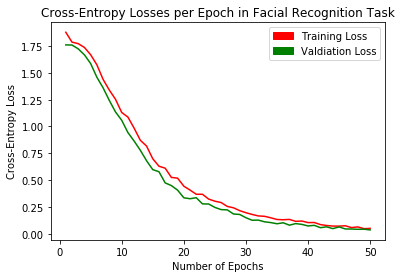

In [18]:
plt.plot(epochs_list, training_loss_0, 'r')
plt.plot(epochs_list, validation_loss_0, 'g')

red_patch = mpatches.Patch(color='red', label='Training Loss')
green_patch = mpatches.Patch(color='green', label='Valdiation Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Losses per Epoch in Facial Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

We can see from the plot that the losses are converging together towards 0, for the facial recognition task. Now we look at the cross entropy losses plot for the gender recognition task.

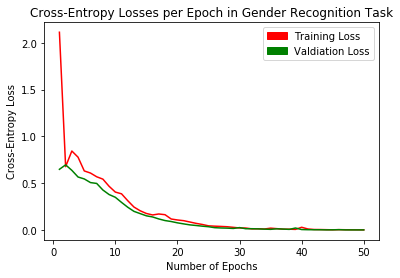

In [19]:
plt.plot(epochs_list, training_loss_1, 'r')
plt.plot(epochs_list, validation_loss_1, 'g')

red_patch = mpatches.Patch(color='red', label='Training Loss')
green_patch = mpatches.Patch(color='green', label='Valdiation Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Losses per Epoch in Gender Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

We can see that the loss for the training loss tends to begin initially higher than the validation loss, for the gender recognition. But as more epochs come in, the two loss values tend to converge altogether as well to 0. And now we look at accuracies, firstly with the facial recognition.

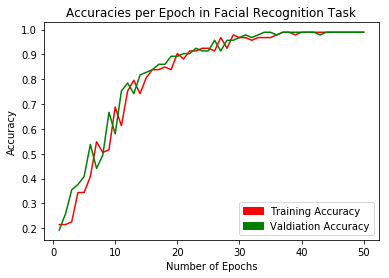

In [20]:
plt.plot(epochs_list, training_acc_0, 'r')
plt.plot(epochs_list, validation_acc_0, 'g')

red_patch = mpatches.Patch(color='red', label='Training Accuracy')
green_patch = mpatches.Patch(color='green', label='Valdiation Accuracy')

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies per Epoch in Facial Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

So as seen, facial recognition training accuracies both tend to 1 the more epochs we go. Let's look at gender recognition.

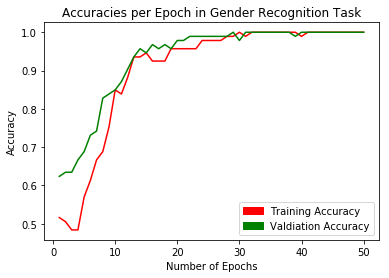

In [21]:
plt.plot(epochs_list, training_acc_1, 'r')
plt.plot(epochs_list, validation_acc_1, 'g')

red_patch = mpatches.Patch(color='red', label='Training Accuracy')
green_patch = mpatches.Patch(color='green', label='Valdiation Accuracy')

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies per Epoch in Gender Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

Training accuracy begins quite low, which is expected given the high loss that initially begins with. But in the long run, the two accuracies for the gender recognition both tend to 1.

### Effects of the Dropout Hyperparameter
We will try a 0.8 dropout, instead of a 0.5 dropout.

In [22]:
# Train the model  for task 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    training_loss_0 = []
    validation_loss_0 = []
    training_acc_0 = []
    validation_acc_0 = []
    epochs_list = []
    
    # Do Training on Facial Recognition
    for epoch in range(epochs):
        batch_train0 = np.shape(trainData0)[0]
        total_batch0 = int(batch_train0/batch_size)
        train_batches_X0 = np.array_split(trainData0[:744], total_batch0)
        train_batches_Y0 = np.array_split(newTrainTarget0[:744], total_batch0)
    
        for i in range(total_batch0):
            train_batch_x0, train_batch_y0 = train_batches_X0[i], train_batches_Y0[i]
            train_batch_x0 = train_batch_x0.reshape(batch_size, n_inputs)
            train_batch_y0 = train_batch_y0.reshape(batch_size, n_classes[0])
            
            # BackProps for Tasks 0, dropouts[1] = 0.8
            sess.run(train_op0,feed_dict={X0: train_batch_x0, y0: train_batch_y0, keep_prob: dropouts[1]})
            if i % step_size == 0 or i == 0:
                training_loss_value0, training_acc_value0 = sess.run([loss0,acc_0], \
                                                                     feed_dict={X0: train_batch_x0, \
                                                                                y0: train_batch_y0, \
                                                                                keep_prob: dropouts[2]})
                training_loss_0.append(training_loss_value0)
                training_acc_0.append(training_acc_value0)
                print("[Facial R.] Epoch " + str(epoch+1) + " - Minibatch Cross-Entropy Loss: " + \
                      "{:.4f}".format(training_loss_value0) + ", Training Accuracy: " + \
                      "{:.4f}".format(training_acc_value0))
                
        valid_batch0 = int(np.shape(validData0)[0]/(batch_size-1))
        valid_batches_X0 = np.array_split(validData0, valid_batch0)
        valid_batches_Y0 = np.array_split(newValidTarget0, valid_batch0)
        
        for j in range(valid_batch0):
            valid_batch_x0, valid_batch_y0 = valid_batches_X0[j], valid_batches_Y0[j]
            valid_batch_x0 = valid_batch_x0.reshape(batch_size-1,n_inputs)
            valid_batch_y0 = valid_batch_y0.reshape(batch_size-1,n_classes[0])
            
            if j % step_size == 0 or j == 0:
                valiation_loss_value0, valiation_acc_value0 = sess.run([loss0,acc_0], \
                                                                       feed_dict={X0: train_batch_x0, \
                                                                                  y0: train_batch_y0,\
                                                                                  keep_prob: dropouts[2]})
                validation_loss_0.append(valiation_loss_value0)
                validation_acc_0.append(valiation_acc_value0)

    print("Training on facial recognition complete.")
    
    ntd0 = testData0[rand].reshape(32,32)
    pred0 = predicted_value_0.eval({X0: testData0[rand], y0: newTestTarget0[rand], keep_prob: dropouts[2]})
    actual0 = actual_value_0.eval({X0: testData0[rand], y0: newTestTarget0[rand], keep_prob: dropouts[2]})

    print("Testing Accuracy on Facial Task: ", acc_0.eval({X0: testData0, y0: newTestTarget0, keep_prob: dropouts[2]}))


[Facial R.] Epoch 1 - Minibatch Cross-Entropy Loss: 1.8766, Training Accuracy: 0.2151
[Facial R.] Epoch 2 - Minibatch Cross-Entropy Loss: 1.7653, Training Accuracy: 0.2688
[Facial R.] Epoch 3 - Minibatch Cross-Entropy Loss: 1.6754, Training Accuracy: 0.4409
[Facial R.] Epoch 4 - Minibatch Cross-Entropy Loss: 1.4798, Training Accuracy: 0.4516
[Facial R.] Epoch 5 - Minibatch Cross-Entropy Loss: 1.2769, Training Accuracy: 0.5591
[Facial R.] Epoch 6 - Minibatch Cross-Entropy Loss: 1.1461, Training Accuracy: 0.6129
[Facial R.] Epoch 7 - Minibatch Cross-Entropy Loss: 1.0166, Training Accuracy: 0.7097
[Facial R.] Epoch 8 - Minibatch Cross-Entropy Loss: 0.8533, Training Accuracy: 0.7527
[Facial R.] Epoch 9 - Minibatch Cross-Entropy Loss: 0.7379, Training Accuracy: 0.7527
[Facial R.] Epoch 10 - Minibatch Cross-Entropy Loss: 0.6402, Training Accuracy: 0.8172
[Facial R.] Epoch 11 - Minibatch Cross-Entropy Loss: 0.6078, Training Accuracy: 0.7957
[Facial R.] Epoch 12 - Minibatch Cross-Entropy Loss:

In [23]:
# Train the model  for task 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    training_loss_1 = []
    validation_loss_1 = []
    training_acc_1 = []
    validation_acc_1 = []
    epochs_list = []
    
    # Do Training on Gender Recognition
    for epoch in range(epochs):
        epochs_list.append(epoch+1)
        
        batch_train1 = np.shape(trainData1)[0]
        total_batch1 = int(batch_train1/batch_size)
        train_batches_X1 = np.array_split(trainData1[:744], total_batch1)
        train_batches_Y1 = np.array_split(newTrainTarget1[:744], total_batch1)
        
        for i in range(total_batch1):
            train_batch_x1, train_batch_y1 = train_batches_X1[i], train_batches_Y1[i]
            train_batch_x1 = train_batch_x1.reshape(batch_size, n_inputs)
            train_batch_y1 = train_batch_y1.reshape(batch_size, n_classes[1])
            
            # BackProps for Task 1
            sess.run(train_op1,feed_dict={X1: train_batch_x1, y1: train_batch_y1, keep_prob: dropouts[1]})
            if i % step_size == 0 or i == 0:
                training_loss_value1, training_acc_value1 = sess.run([loss1,acc_1], \
                                                                     feed_dict={X1: train_batch_x1, \
                                                                                y1: train_batch_y1, \
                                                                                keep_prob: dropouts[2]})
                training_loss_1.append(training_loss_value1)
                training_acc_1.append(training_acc_value1)
                print("[Gender R.] Epoch " + str(epoch+1) + " - Minibatch Cross-Entropy Loss: " + \
                      "{:.4f}".format(training_loss_value1) + ", Training Accuracy: " + \
                      "{:.4f}".format(training_acc_value1))
                
        valid_batch1 = int(np.shape(validData1)[0]/(batch_size-1))
        valid_batches_X1 = np.array_split(validData1, valid_batch1)
        valid_batches_Y1 = np.array_split(newValidTarget1, valid_batch1)
        
        for j in range(valid_batch0):
            valid_batch_x1, valid_batch_y1 = valid_batches_X1[j], valid_batches_Y1[j]
            valid_batch_x1 = valid_batch_x1.reshape(batch_size-1,n_inputs)
            valid_batch_y1 = valid_batch_y1.reshape(batch_size-1,n_classes[1])
            
            if j % step_size == 0 or j == 0:
                valiation_loss_value1, valiation_acc_value1 = sess.run([loss1,acc_1], \
                                                                       feed_dict={X1: train_batch_x1, \
                                                                                  y1: train_batch_y1,\
                                                                                  keep_prob: dropouts[2]})
                validation_loss_1.append(valiation_loss_value1)
                validation_acc_1.append(valiation_acc_value1)

    print("Training on gender recognition complete.")
    
    ntd1 = testData1[rand].reshape(32,32)
    pred1 = predicted_value_1.eval({X1: testData1[rand], y1: newTestTarget1[rand], keep_prob: dropouts[2]})
    actual1 = actual_value_1.eval({X1: testData1[rand], y1: newTestTarget1[rand], keep_prob: dropouts[2]})

    print("Testing Accuracy on Gender Task: ", acc_1.eval({X1: testData1, y1: newTestTarget1, keep_prob: dropouts[2]}))


[Gender R.] Epoch 1 - Minibatch Cross-Entropy Loss: 2.1734, Training Accuracy: 0.5161
[Gender R.] Epoch 2 - Minibatch Cross-Entropy Loss: 0.7099, Training Accuracy: 0.4839
[Gender R.] Epoch 3 - Minibatch Cross-Entropy Loss: 0.6504, Training Accuracy: 0.5806
[Gender R.] Epoch 4 - Minibatch Cross-Entropy Loss: 0.6098, Training Accuracy: 0.6452
[Gender R.] Epoch 5 - Minibatch Cross-Entropy Loss: 0.5502, Training Accuracy: 0.7204
[Gender R.] Epoch 6 - Minibatch Cross-Entropy Loss: 0.4832, Training Accuracy: 0.7527
[Gender R.] Epoch 7 - Minibatch Cross-Entropy Loss: 0.4255, Training Accuracy: 0.8387
[Gender R.] Epoch 8 - Minibatch Cross-Entropy Loss: 0.3648, Training Accuracy: 0.9032
[Gender R.] Epoch 9 - Minibatch Cross-Entropy Loss: 0.3149, Training Accuracy: 0.9140
[Gender R.] Epoch 10 - Minibatch Cross-Entropy Loss: 0.2674, Training Accuracy: 0.9247
[Gender R.] Epoch 11 - Minibatch Cross-Entropy Loss: 0.2409, Training Accuracy: 0.9355
[Gender R.] Epoch 12 - Minibatch Cross-Entropy Loss:

And here are the plots.

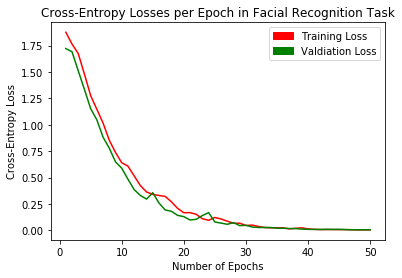

In [24]:
plt.plot(epochs_list, training_loss_0, 'r')
plt.plot(epochs_list, validation_loss_0, 'g')

red_patch = mpatches.Patch(color='red', label='Training Loss')
green_patch = mpatches.Patch(color='green', label='Valdiation Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Losses per Epoch in Facial Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

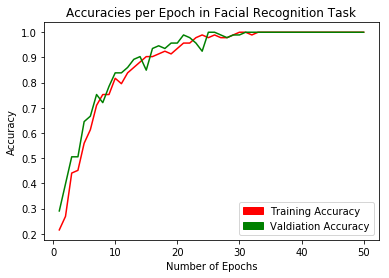

In [25]:
plt.plot(epochs_list, training_acc_0, 'r')
plt.plot(epochs_list, validation_acc_0, 'g')

red_patch = mpatches.Patch(color='red', label='Training Accuracy')
green_patch = mpatches.Patch(color='green', label='Valdiation Accuracy')

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies per Epoch in Facial Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

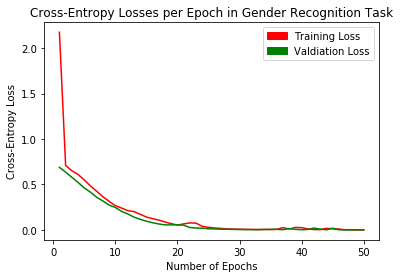

In [26]:
plt.plot(epochs_list, training_loss_1, 'r')
plt.plot(epochs_list, validation_loss_1, 'g')

red_patch = mpatches.Patch(color='red', label='Training Loss')
green_patch = mpatches.Patch(color='green', label='Valdiation Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Losses per Epoch in Gender Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

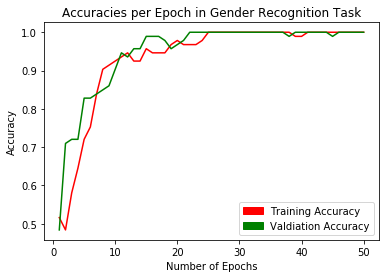

In [27]:
plt.plot(epochs_list, training_acc_1, 'r')
plt.plot(epochs_list, validation_acc_1, 'g')

red_patch = mpatches.Patch(color='red', label='Training Accuracy')
green_patch = mpatches.Patch(color='green', label='Valdiation Accuracy')

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies per Epoch in Gender Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

#### Some Observations
We can see that losses and accuracies in general tend to converge faster, with the performances increasing significantly. For instance, the testing accuracy of the facial recognition task increased from 88.2% to 90.3%; while the testing accuracy of the gender recognition task increased from 97.8% to 98.9%.

### Effects of the Learning Rate Hyperparameter
We will be updating the learning rate hyperparameter to be 0.0005.

In [28]:
opt0 = tf.train.AdamOptimizer(learning_rate=learning_rates[1]) #learning_rates[1] = 0.0005
train_op0 = opt0.minimize(loss0)
opt1 = tf.train.AdamOptimizer(learning_rate=learning_rates[1])
train_op1 = opt1.minimize(loss1)

predicted_value_0 = tf.argmax(prediction0, 1)
predicted_value_1 = tf.argmax(prediction1, 1)
actual_value_0 = tf.argmax(y0,1)
actual_value_1 = tf.argmax(y1,1)
correct_predictions0 = tf.equal(predicted_value_0, actual_value_0)
acc_0 = tf.reduce_mean(tf.cast(correct_predictions0, tf.float32))
correct_predictions1 = tf.equal(predicted_value_1, actual_value_1)
acc_1 = tf.reduce_mean(tf.cast(correct_predictions1, tf.float32))

In [29]:
# Train the model  for task 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    training_loss_0 = []
    validation_loss_0 = []
    training_acc_0 = []
    validation_acc_0 = []
    epochs_list = []
    
    # Do Training on Facial Recognition
    for epoch in range(epochs):
        batch_train0 = np.shape(trainData0)[0]
        total_batch0 = int(batch_train0/batch_size)
        train_batches_X0 = np.array_split(trainData0[:744], total_batch0)
        train_batches_Y0 = np.array_split(newTrainTarget0[:744], total_batch0)
    
        for i in range(total_batch0):
            train_batch_x0, train_batch_y0 = train_batches_X0[i], train_batches_Y0[i]
            train_batch_x0 = train_batch_x0.reshape(batch_size, n_inputs)
            train_batch_y0 = train_batch_y0.reshape(batch_size, n_classes[0])
            
            # BackProps for Tasks 0
            sess.run(train_op0,feed_dict={X0: train_batch_x0, y0: train_batch_y0, keep_prob: dropouts[0]})
            if i % step_size == 0 or i == 0:
                training_loss_value0, training_acc_value0 = sess.run([loss0,acc_0], \
                                                                     feed_dict={X0: train_batch_x0, \
                                                                                y0: train_batch_y0, \
                                                                                keep_prob: dropouts[2]})
                training_loss_0.append(training_loss_value0)
                training_acc_0.append(training_acc_value0)
                print("[Facial R.] Epoch " + str(epoch+1) + " - Minibatch Cross-Entropy Loss: " + \
                      "{:.4f}".format(training_loss_value0) + ", Training Accuracy: " + \
                      "{:.4f}".format(training_acc_value0))
                
        valid_batch0 = int(np.shape(validData0)[0]/(batch_size-1))
        valid_batches_X0 = np.array_split(validData0, valid_batch0)
        valid_batches_Y0 = np.array_split(newValidTarget0, valid_batch0)
        
        for j in range(valid_batch0):
            valid_batch_x0, valid_batch_y0 = valid_batches_X0[j], valid_batches_Y0[j]
            valid_batch_x0 = valid_batch_x0.reshape(batch_size-1,n_inputs)
            valid_batch_y0 = valid_batch_y0.reshape(batch_size-1,n_classes[0])
            
            if j % step_size == 0 or j == 0:
                valiation_loss_value0, valiation_acc_value0 = sess.run([loss0,acc_0], \
                                                                       feed_dict={X0: train_batch_x0, \
                                                                                  y0: train_batch_y0,\
                                                                                  keep_prob: dropouts[2]})
                validation_loss_0.append(valiation_loss_value0)
                validation_acc_0.append(valiation_acc_value0)

    print("Training on facial recognition complete.")
    
    ntd0 = testData0[rand].reshape(32,32)
    pred0 = predicted_value_0.eval({X0: testData0[rand], y0: newTestTarget0[rand], keep_prob: dropouts[2]})
    actual0 = actual_value_0.eval({X0: testData0[rand], y0: newTestTarget0[rand], keep_prob: dropouts[2]})

    print("Testing Accuracy on Facial Task: ", acc_0.eval({X0: testData0, y0: newTestTarget0, keep_prob: dropouts[2]}))

[Facial R.] Epoch 1 - Minibatch Cross-Entropy Loss: 1.7934, Training Accuracy: 0.2366
[Facial R.] Epoch 2 - Minibatch Cross-Entropy Loss: 1.7494, Training Accuracy: 0.2151
[Facial R.] Epoch 3 - Minibatch Cross-Entropy Loss: 1.7417, Training Accuracy: 0.3441
[Facial R.] Epoch 4 - Minibatch Cross-Entropy Loss: 1.7299, Training Accuracy: 0.2366
[Facial R.] Epoch 5 - Minibatch Cross-Entropy Loss: 1.7028, Training Accuracy: 0.3978
[Facial R.] Epoch 6 - Minibatch Cross-Entropy Loss: 1.6633, Training Accuracy: 0.3871
[Facial R.] Epoch 7 - Minibatch Cross-Entropy Loss: 1.5904, Training Accuracy: 0.5054
[Facial R.] Epoch 8 - Minibatch Cross-Entropy Loss: 1.5564, Training Accuracy: 0.5161
[Facial R.] Epoch 9 - Minibatch Cross-Entropy Loss: 1.5007, Training Accuracy: 0.5484
[Facial R.] Epoch 10 - Minibatch Cross-Entropy Loss: 1.4079, Training Accuracy: 0.5806
[Facial R.] Epoch 11 - Minibatch Cross-Entropy Loss: 1.3728, Training Accuracy: 0.5699
[Facial R.] Epoch 12 - Minibatch Cross-Entropy Loss:

In [30]:
# Train the model  for task 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    training_loss_1 = []
    validation_loss_1 = []
    training_acc_1 = []
    validation_acc_1 = []
    epochs_list = []
    
    # Do Training on Gender Recognition
    for epoch in range(epochs):
        epochs_list.append(epoch+1)
        
        batch_train1 = np.shape(trainData1)[0]
        total_batch1 = int(batch_train1/batch_size)
        train_batches_X1 = np.array_split(trainData1[:744], total_batch1)
        train_batches_Y1 = np.array_split(newTrainTarget1[:744], total_batch1)
        
        for i in range(total_batch1):
            training_loss_value1, training_acc_value1 = sess.run([loss1,acc_1], \
                                                                     feed_dict={X1: train_batch_x1, \
                                                                                y1: train_batch_y1, \
                                                                                keep_prob: dropouts[2]})
            train_batch_x1, train_batch_y1 = train_batches_X1[i], train_batches_Y1[i]
            train_batch_x1 = train_batch_x1.reshape(batch_size, n_inputs)
            train_batch_y1 = train_batch_y1.reshape(batch_size, n_classes[1])
            
            # BackProps for Task 1
            sess.run(train_op1,feed_dict={X1: train_batch_x1, y1: train_batch_y1, keep_prob: dropouts[0]})
            if i % step_size == 0 or i == 0:
                training_loss_1.append(training_loss_value1)
                training_acc_1.append(training_acc_value1)
                print("[Gender R.] Epoch " + str(epoch+1) + " - Minibatch Cross-Entropy Loss: " + \
                      "{:.4f}".format(training_loss_value1) + ", Training Accuracy: " + \
                      "{:.4f}".format(training_acc_value1))
                
        valid_batch1 = int(np.shape(validData1)[0]/(batch_size-1))
        valid_batches_X1 = np.array_split(validData1, valid_batch1)
        valid_batches_Y1 = np.array_split(newValidTarget1, valid_batch1)
        
        for j in range(valid_batch0):
            valid_batch_x1, valid_batch_y1 = valid_batches_X1[j], valid_batches_Y1[j]
            valid_batch_x1 = valid_batch_x1.reshape(batch_size-1,n_inputs)
            valid_batch_y1 = valid_batch_y1.reshape(batch_size-1,n_classes[1])
            
            if j % step_size == 0 or j == 0:
                valiation_loss_value1, valiation_acc_value1 = sess.run([loss1,acc_1], \
                                                                       feed_dict={X1: train_batch_x1, \
                                                                                  y1: train_batch_y1,\
                                                                                  keep_prob: dropouts[2]})
                validation_loss_1.append(valiation_loss_value1)
                validation_acc_1.append(valiation_acc_value1)

    print("Training on gender recognition complete.")
    
    ntd1 = testData1[rand].reshape(32,32)
    pred1 = predicted_value_1.eval({X1: testData1[rand], y1: newTestTarget1[rand], keep_prob: dropouts[2]})
    actual1 = actual_value_1.eval({X1: testData1[rand], y1: newTestTarget1[rand], keep_prob: dropouts[2]})

    print("Testing Accuracy on Gender Task: ", acc_1.eval({X1: testData1, y1: newTestTarget1, keep_prob: dropouts[2]}))


[Gender R.] Epoch 1 - Minibatch Cross-Entropy Loss: 0.7162, Training Accuracy: 0.3763
[Gender R.] Epoch 2 - Minibatch Cross-Entropy Loss: 0.6350, Training Accuracy: 0.6344
[Gender R.] Epoch 3 - Minibatch Cross-Entropy Loss: 0.6447, Training Accuracy: 0.6344
[Gender R.] Epoch 4 - Minibatch Cross-Entropy Loss: 0.6195, Training Accuracy: 0.6452
[Gender R.] Epoch 5 - Minibatch Cross-Entropy Loss: 0.5618, Training Accuracy: 0.7527
[Gender R.] Epoch 6 - Minibatch Cross-Entropy Loss: 0.5044, Training Accuracy: 0.8065
[Gender R.] Epoch 7 - Minibatch Cross-Entropy Loss: 0.4581, Training Accuracy: 0.8280
[Gender R.] Epoch 8 - Minibatch Cross-Entropy Loss: 0.4216, Training Accuracy: 0.8602
[Gender R.] Epoch 9 - Minibatch Cross-Entropy Loss: 0.3866, Training Accuracy: 0.8495
[Gender R.] Epoch 10 - Minibatch Cross-Entropy Loss: 0.3566, Training Accuracy: 0.8602
[Gender R.] Epoch 11 - Minibatch Cross-Entropy Loss: 0.3342, Training Accuracy: 0.8710
[Gender R.] Epoch 12 - Minibatch Cross-Entropy Loss:

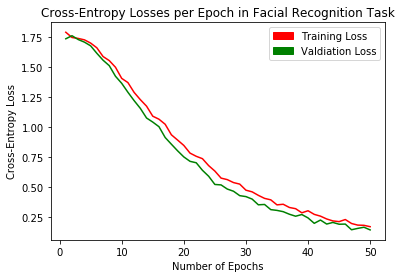

In [31]:
plt.plot(epochs_list, training_loss_0, 'r')
plt.plot(epochs_list, validation_loss_0, 'g')

red_patch = mpatches.Patch(color='red', label='Training Loss')
green_patch = mpatches.Patch(color='green', label='Valdiation Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Losses per Epoch in Facial Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

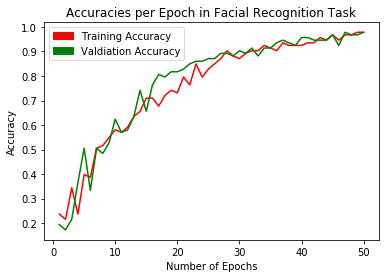

In [32]:
plt.plot(epochs_list, training_acc_0, 'r')
plt.plot(epochs_list, validation_acc_0, 'g')

red_patch = mpatches.Patch(color='red', label='Training Accuracy')
green_patch = mpatches.Patch(color='green', label='Valdiation Accuracy')

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies per Epoch in Facial Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

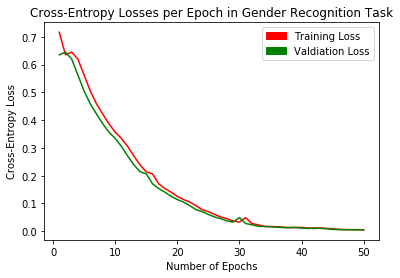

In [33]:
plt.plot(epochs_list, training_loss_1, 'r')
plt.plot(epochs_list, validation_loss_1, 'g')

red_patch = mpatches.Patch(color='red', label='Training Loss')
green_patch = mpatches.Patch(color='green', label='Valdiation Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Losses per Epoch in Gender Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

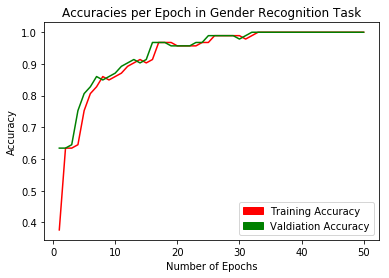

In [34]:
plt.plot(epochs_list, training_acc_1, 'r')
plt.plot(epochs_list, validation_acc_1, 'g')

red_patch = mpatches.Patch(color='red', label='Training Accuracy')
green_patch = mpatches.Patch(color='green', label='Valdiation Accuracy')

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies per Epoch in Gender Recognition Task')
plt.legend(handles=[red_patch, green_patch])
plt.show()

#### Some Observations
Considering we still use the same dropout as the original, then we can see that the testing accuracy for facial recognition stays the same almost at 88.2%; while the gender recognition training accuracy decreased slightly lower from 97.8% to 96.7%.

### Visualization
Now let us have a look at the visualization and test out on a sample, random data. And see if it is able to predict the celebrity's name and gender.

In [35]:
celebrities = ['Lorraine Bracco', 'Gerard Butler', 'Peri Gilpin', 'Angie Harmon', 
               'Daniel Radcliffe', 'Michael Vartan']
genders = ['Male', 'Female']

Predicted Celebrity:  Lorraine Bracco  is  Female
Actual Celebrity:  Lorraine Bracco  is  Female
The facial prediction is  correct
The gender prediction is  correct


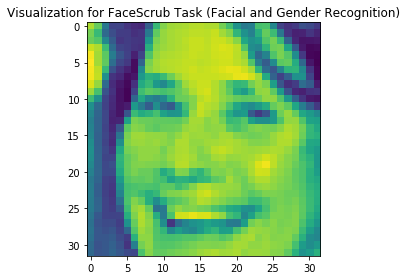

In [36]:
print("Predicted Celebrity: ", celebrities[pred0[0]], " is ", genders[pred1[0]])
print("Actual Celebrity: ", celebrities[actual0[0]], " is ", genders[actual1[0]])
f_result = "correct" if celebrities[pred0[0]] == celebrities[actual0[0]]  else "incorrect"
print("The facial prediction is ", f_result)
g_result = "correct" if genders[pred1[0]] == genders[actual1[0]]  else "incorrect"
print("The gender prediction is ", g_result)

heatmap, axis = plt.subplots()
im = axis.imshow(ntd0)

axis.set_title("Visualization for FaceScrub Task (Facial and Gender Recognition)")
heatmap.tight_layout()
plt.show()